# Let's kill off `Runner`

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
#export
from exp.nb_09 import *

In [4]:
AvgStats

exp.nb_04.AvgStats

## Imagenette data

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=6571)

In [5]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [6]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [7]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [8]:
nfs = [32]*4

Having a Runner is great but not essential when the `Learner` already has everything needed in its state. We implement everything inside it directly instead of building a second object.

##### In Lesson 12 Jeremy Howard revisited material in the cell below  [Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=65)

In [9]:
#export
def param_getter(m): return m.parameters()

class Learner():
    def __init__(self, model, data, loss_func, opt_func=sgd_opt, lr=1e-2, splitter=param_getter,
                 cbs=None, cb_funcs=None):
        self.model,self.data,self.loss_func,self.opt_func,self.lr,self.splitter = model,data,loss_func,opt_func,lr,splitter
        self.in_train,self.logger,self.opt = False,print,None
        
        # NB: Things marked "NEW" are covered in lesson 12
        # NEW: avoid need for set_runner
        self.cbs = []
        self.add_cb(TrainEvalCallback())
        self.add_cbs(cbs)
        self.add_cbs(cbf() for cbf in listify(cb_funcs))

    def add_cbs(self, cbs):
        for cb in listify(cbs): self.add_cb(cb)
            
    def add_cb(self, cb):
        cb.set_runner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def remove_cbs(self, cbs):
        for cb in listify(cbs): self.cbs.remove(cb)
            
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb,self.yb = xb,yb;                        self('begin_batch')
            self.pred = self.model(self.xb);                self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb); self('after_loss')
            if not self.in_train: return
            self.loss.backward();                           self('after_backward')
            self.opt.step();                                self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

    def all_batches(self):
        self.iters = len(self.dl)
        try:
            for i,(xb,yb) in enumerate(self.dl): self.one_batch(i, xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def do_begin_fit(self, epochs):
        self.epochs,self.loss = epochs,tensor(0.)
        self('begin_fit')

    def do_begin_epoch(self, epoch):
        self.epoch,self.dl = epoch,self.data.train_dl
        return self('begin_epoch')

    def fit(self, epochs, cbs=None, reset_opt=False):
        # NEW: pass callbacks to fit() and have them removed when done
        self.add_cbs(cbs)
        # NEW: create optimizer on fit(), optionally replacing existing
        if reset_opt or not self.opt: self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
            
        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                self.do_begin_epoch(epoch)
                if not self('begin_epoch'): self.all_batches()

                with torch.no_grad(): 
                    self.dl = self.data.valid_dl
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)

    ALL_CBS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_validate', 'after_epoch',
        'after_cancel_train', 'after_fit'}
    
    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

In [10]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        #We use the logger function of the `Learner` here, it can be customized to write in a file or in a progress bar
        self.logger(self.train_stats)
        self.logger(self.valid_stats) 

In [11]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [12]:
#export
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=sgd_opt, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [13]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [14]:
%time learn.fit(1)

train: [1.7519862981328524, tensor(0.3937, device='cuda:0')]
valid: [1.476786865234375, tensor(0.4820, device='cuda:0')]
CPU times: user 5.42 s, sys: 1.9 s, total: 7.31 s
Wall time: 7.65 s


## Check everything works

Let's check our previous callbacks still work.

In [15]:
cbfs += [Recorder]

In [16]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [17]:
phases = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.2, 0.6, 0.2))
sched = ParamScheduler('lr', phases)

In [18]:
learn.fit(1, sched)

train: [1.7562164027357685, tensor(0.3881, device='cuda:0')]
valid: [1.391839599609375, tensor(0.5360, device='cuda:0')]


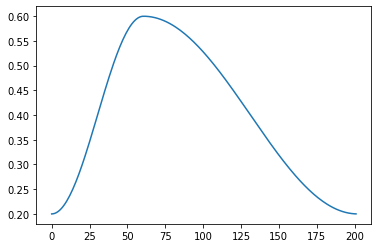

In [19]:
learn.recorder.plot_lr()

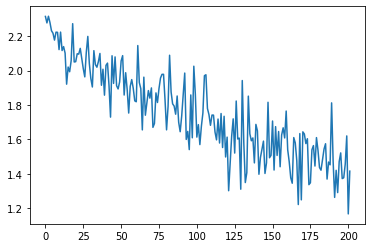

In [20]:
learn.recorder.plot_loss()

### Check `Learner.__call__`

The `__call__` method of `Learner` can't ever return `True`.  Is this the case, and is it a problem?

```python
    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res
```

Below are several scenarios with made-up results from 4 callbacks.  Different scenarios have different number of `True`s.  All of them return either `None` or `False`.

In [21]:
res = False
rs = [None, None, None, None]
for r in rs: res = r and res
print(res)

None


In [22]:
res = False
rs = [None, 1, None, None]
for r in rs: res = r and res
print(res)

None


In [23]:
res = False
rs = [None, True, None, None]
for r in rs: res = r and res
print(res)

None


In [24]:
res = False
rs = [True, True, None, None]
for r in rs: res = r and res
print(res)

None


In [25]:
res = False
rs = [True, True, True, True]
for r in rs: res = r and res
print(res)

False


Let's try to skip validation by making `self('begin_validate')` equal to `True`.  The only callback that handles this event is `TrainEvalCallBack`.

In [26]:
learn.cbs

In [27]:
[cb for cb in learn.cbs if getattr(cb, 'begin_validate', None)]

Let's inherit from it and over-ride its `begin_validate` method to return `True`.  This ought to skip the validation section in `Learner.fit`.

In [28]:
class TrainOnlyCallback(TrainEvalCallback):
    def begin_validate(self): return True

In [29]:
cbfs += [TrainOnlyCallback]

In [30]:
cbfs

[functools.partial(<class '__main__.AvgStatsCallback'>, <function accuracy at 0x7fabaee31830>),
 exp.nb_06.CudaCallback,
 functools.partial(<class 'exp.nb_06.BatchTransformXCallback'>, functools.partial(<function normalize_chan at 0x7fab640d90e0>, mean=tensor([0.4700, 0.4800, 0.4500], device='cuda:0'), std=tensor([0.2900, 0.2800, 0.3000], device='cuda:0'))),
 exp.nb_09.Recorder,
 __main__.TrainOnlyCallback]

In [31]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

It appears that validation is still carried out because the loss and accuracy are still there.

In [32]:
learn.fit(1)

train: [1.7616778516170313, tensor(0.3890, device='cuda:0')]
valid: [2.348386474609375, tensor(0.3220, device='cuda:0')]


If `Learner.__call__` is changed to:

```python
    def __call__(self, cb_name):
        assert cb_name in self.ALL_CBS
        return any(cb(cb_name) for cb in sorted(self.cbs, key=lambda x: x._order))
```

In [33]:
def newdundercall(self, cb_name):
    assert cb_name in self.ALL_CBS
    return any(cb(cb_name) for cb in sorted(self.cbs, key=lambda x: x._order))

Learner.__call__ = newdundercall

In [34]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

Validation no longer seems to happen.  The learner and model are both still in training mode.  The learner's dataloader has already been changed to the validation dataloader though.

In [35]:
learn.fit(1)

train: [1.7522828871471228, tensor(0.3867, device='cuda:0')]



In [36]:
learn.in_train, learn.model.training, len(learn.dl.dataset), len(learn.data.valid_ds)

(False, False, 500, 500)

## Export

In [37]:
!./notebook2script.py 09b_learner.ipynb

Traceback (most recent call last):
  File "./notebook2script.py", line 3, in <module>
    import json,fire,re
ModuleNotFoundError: No module named 'fire'
